# Time Series Analysis Final Report for the brand Macys
### Author : Ramya Prabhakar

### Summary : 
The goal of this analysis is to understand the driving factors behind Google search interest for Macys.

#### Import necessary libraries

In [127]:
import matplotlib.dates as mdates
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
from statsmodels.tsa import seasonal
from fbprophet import Prophet
import holidays
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from statistics import mode
from statsmodels.tsa import stattools
import seaborn as sns
from search_sampler import SearchSampler



#### Pull Macy's google search trends data and decompose the same

In [118]:
macys = pd.read_csv('macys.googletrends.csv')

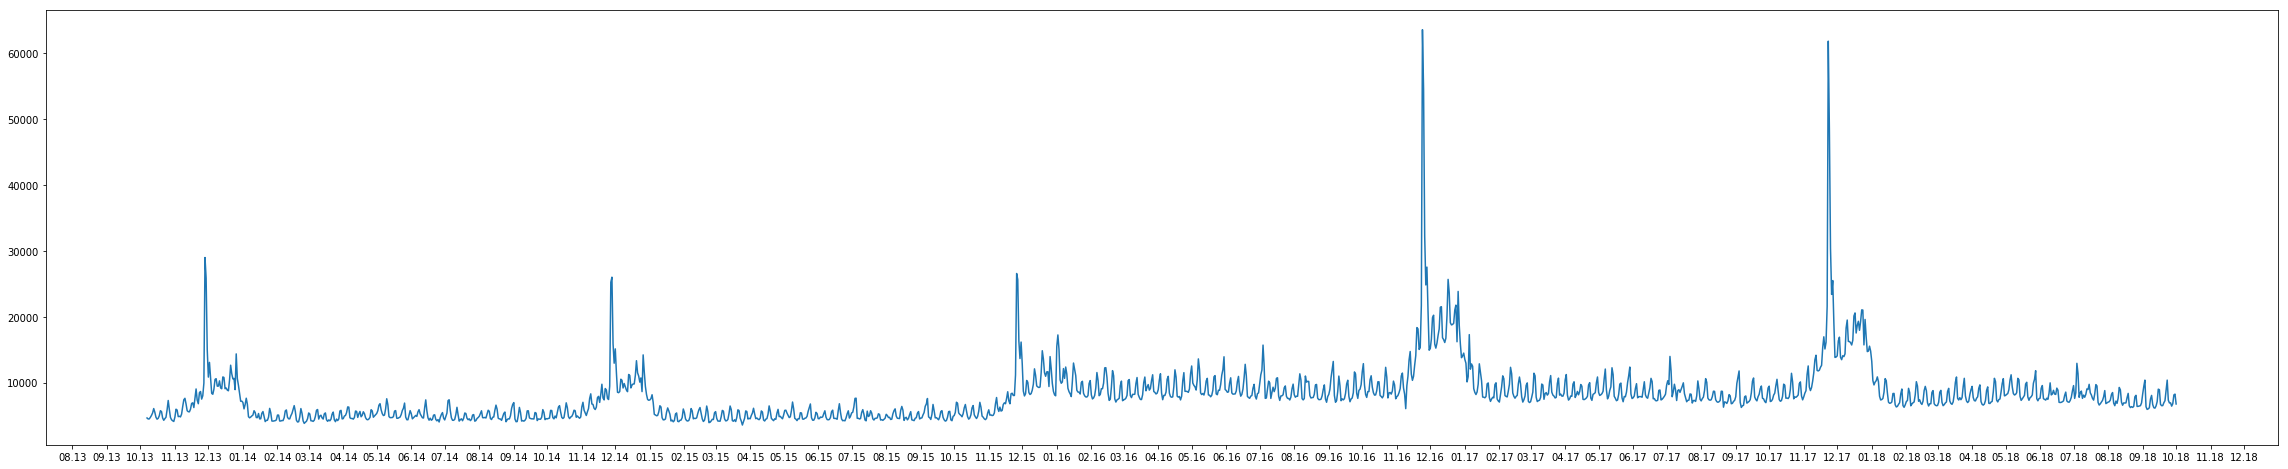

In [119]:
macys = pd.read_csv("macys.googletrends.csv", parse_dates=['period']) 
macys['period'] = macys['period'].dt.date
macys.set_index('period', inplace=True)

dimensions = (40,8)
fig, ax = pyplot.subplots(figsize=dimensions)
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearmonth = mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)
ax.plot(macys.index, macys['value'])

#test if the data is stationary
adf_result = stattools.adfuller(macys['value'])
#check if this result is stationary or not. index 1 < 0.05; people use 0.01 as a cutoff too.


The stationarity test proves that the data is stationary. Hence, proceed with the same data for analysis. The first plot shows two major spikes in the data and needs to analyzed in detail.

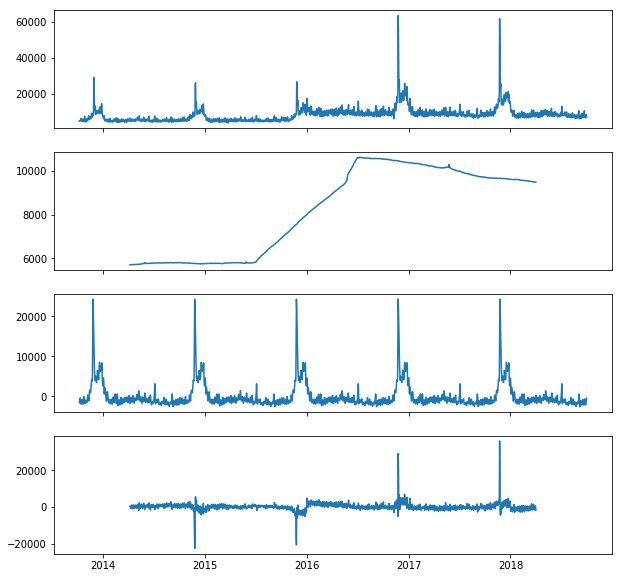

In [120]:
decompose_model = seasonal.seasonal_decompose(macys['value'].tolist(), freq=365, model='additive')
dir(decompose_model)

dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex ='all')

ax1.plot(macys.index, macys['value'])
ax2.plot(macys.index, decompose_model.trend)
ax3.plot(macys.index, decompose_model.seasonal)
ax4.plot(macys.index, decompose_model.resid)

Splitting our information into 4 different charts is certainly more informative. 

The first chart is identical to our original model and shows our values over time.

The second chart shows an upward trend around mid 2015 but then confirms our concern that we are seeing an overall downward trend beginning last quarter of 2016. This drop is rather evident and calls for an in depth analysis.

The third chart confirms our theory that there is a strong year over year seasonal trend. 

The final chart shows our model's residuals, indicating there are moments of greater and less accuracy depending on year and season.

Next: Let's add the seasonal column to our dataset and see how it looks for the year 2015

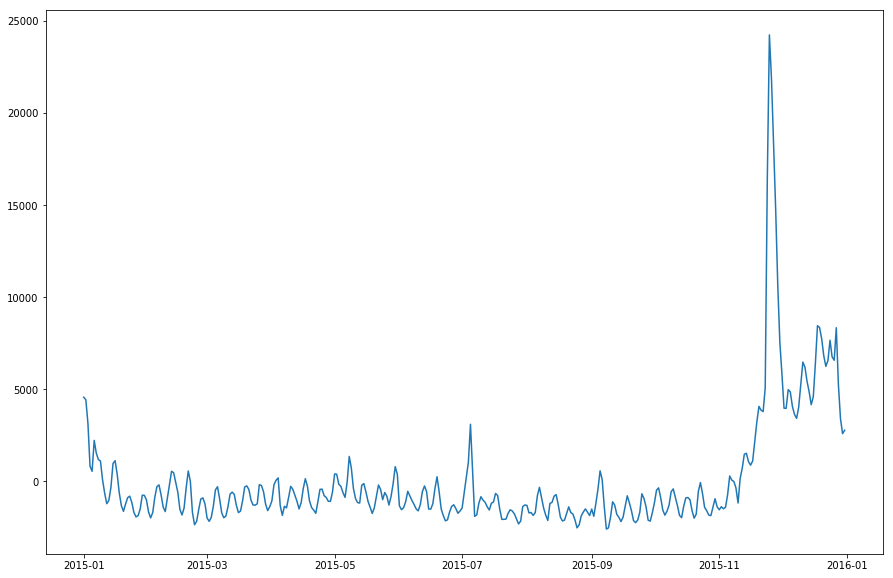

In [122]:
macys['seasonal'] = decompose_model.seasonal
startdate = pd.to_datetime("2015-01-01").date()
enddate = pd.to_datetime("2015-12-31").date()
oneyear = macys.loc[startdate:enddate]

dimensions = (15,10)
fig, ax1 = pyplot.subplots(figsize=dimensions)
pyplot.plot(oneyear.index, oneyear.seasonal)

Now let's move into the Facebook Prophet analysis

#### Prophet Time Series Analysis

In [7]:
macys = pd.read_csv('macys.googletrends.csv', parse_dates = ['period'])
#macys.head()

In [8]:
prophetdataframe = pd.DataFrame()
# create a dataframe

In [9]:
prophetdataframe['ds'] = macys['period']
prophetdataframe['y'] = macys['value']
# add the required fields to the dataframe

In [10]:
prophetdataframe.head()

,ds,y
0,2013-10-07,4643.368256
1,2013-10-08,4492.723981
2,2013-10-09,4503.579896
3,2013-10-10,4741.994493
4,2013-10-11,5034.404350


In [11]:
m=Prophet()
m.fit(prophetdataframe)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=365)

In [13]:
future.tail()

,ds
2181,2019-09-27
2182,2019-09-28
2183,2019-09-29
2184,2019-09-30
2185,2019-10-01


In [14]:
forecast = m.predict(future)


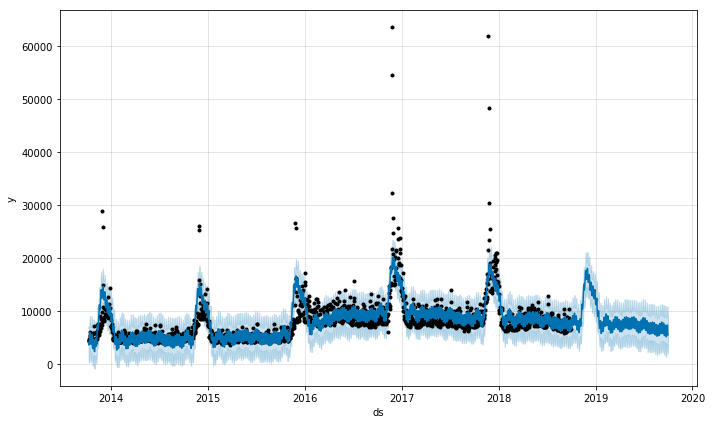

In [15]:
fig1 = m.plot(forecast)

The black dots are observed values.The dark blue section is the error in the observation for each day. It is quite narrow in this case, so we see pretty small error in our model. The light blue shade is the confidence interval at the 95th percentile.
The better our model, the more we will see our actual values fall within the light blue range.

This model appears to be rather accurate and tells me that the error ratio is pretty small and most of the data points fall within the 95% confidence interval. However, there are several outliers that need to be investigated. Of particular interest is the bunch of outliers that occur towards the end of 2016 and 2017. The residuals are pretty uniform across the years with the exception of the late 2016 and also the year end of 2017. 

This corresponds to the time that Amazon and other e-commerce sites created a negative impact on Macys sales and after a particularly bad sales season, the corporate decided to shut down nearly 15% of their stores (68 stores) nationwide in August 2016. The stores were closed in early 2017 and they all had final clearance sales, hence the high interest. A further closure of 34 stores was announced in the late 2017 early 2018 time frame and this caused the high interest outside of normal range

There are also outliers closer to the Black Friday weekends every year and this corresponds to the maximum sales season. This will be addressed when adding the holiday list.

#### Now graph the individual components

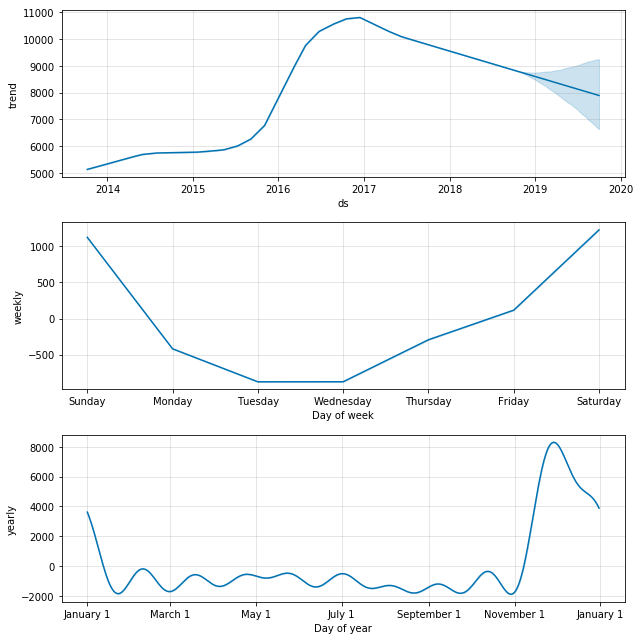

In [16]:
fig2 = m.plot_components(forecast)

There is a steady downward trend starting from 2017 onwards and the forecast also seems to continue with  the downward trend, with equal probability of it either going upward or downward in the future. 
The downward trend can be attributed to the new CEO Jeffery Gennette who took over almost two years ago on March 23rd 2017 and the major changes he proposed, including having fewer coupons for customers and reducing the number of sales associates available to help customers. Besides this, the fact that e-commerce affects nearly most of the brick and mortar stores is also a strong reason for this downward trend.

Saturdays and Sundays are the best days of the week in terms of search, given that most of Macy's customers are salaried people who work Monday through Friday. Mid week, Tuesday and Wednesday in particular have the least search volume while it gradually increases on Wednesday and Friday with a sharper increase on Saturday. There is a slight decrease in search on Sunday as most families begin to prepare for the week ahead and then a drastic drop on Monday of almost 1500 units before hitting the low on Tuesday.

There is some amount of yearly seasonality. Every year, there is a peak in November end, corresponding to the Black Friday sales and two smaller peaks one each around Christmas and in January probably when people want to return/exchange their gifts/purchases.
Seasonality is mainly driven by the brand. Based on the holiday sales they announce during Black Friday and Christmas, the seasonality exists

In [17]:
forecast.to_csv('forecast.csv')

In [18]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

erroranalysis.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresiduals
0,2013-10-07,5133.537003,555.111111,6954.423032,5133.537003,5133.537003,-1114.613680,-1114.613680,-1114.613680,-419.392527,...,-695.221153,-695.221153,-695.221153,0.0,0.0,0.0,4018.923323,4643.368256,624.444933,624.444933
1,2013-10-08,5135.960424,333.955782,6847.787076,5135.960424,5135.960424,-1472.489289,-1472.489289,-1472.489289,-876.479330,...,-596.009959,-596.009959,-596.009959,0.0,0.0,0.0,3663.471136,4492.723981,829.252845,829.252845
2,2013-10-09,5138.383846,373.997188,7167.263485,5138.383846,5138.383846,-1385.864954,-1385.864954,-1385.864954,-875.844845,...,-510.020109,-510.020109,-510.020109,0.0,0.0,0.0,3752.518892,4503.579896,751.061004,751.061004
3,2013-10-10,5140.807268,859.045051,7526.671352,5140.807268,5140.807268,-734.387803,-734.387803,-734.387803,-294.288937,...,-440.098865,-440.098865,-440.098865,0.0,0.0,0.0,4406.419465,4741.994493,335.575028,335.575028
4,2013-10-11,5143.230689,1503.282252,7987.598196,5143.230689,5143.230689,-273.212420,-273.212420,-273.212420,115.507520,...,-388.719940,-388.719940,-388.719940,0.0,0.0,0.0,4870.018269,5034.404350,164.386081,164.386081


In [19]:
#look at the average total error and take the sq root, to get an approximate root mean square error
totalerror = erroranalysis['absoluteresiduals'].sum()

In [20]:
print(totalerror/len(erroranalysis))

1158.369990188668


In [21]:
# now inspect the outliers. why did that brand outperform itself on that day or tank terribly
print(erroranalysis.nlargest(20, 'absoluteresiduals'))

             ds         trend    yhat_lower    yhat_upper   trend_lower  \
1144 2016-11-24  10785.140221  14848.109187  21466.186415  10785.140221   
1508 2017-11-23   9651.434128  13529.888869  20019.829012   9651.434128   
1145 2016-11-25  10785.994081  15349.868954  22035.288897  10785.994081   
1509 2017-11-24   9648.834778  14340.356078  20683.408929   9648.834778   
52   2013-11-28   5259.554927   9945.837969  16157.050564   5259.554927   
53   2013-11-29   5261.978349  10474.904390  17075.250324   5261.978349   
1146 2016-11-26  10786.847941  16725.115346  23345.958833  10786.847941   
417  2014-11-28   5766.282567  10888.467512  17354.745926   5766.282567   
780  2015-11-26   7173.918041  11789.797864  18098.747130   7173.918041   
416  2014-11-27   5766.112607  10259.985382  16751.011004   5766.112607   
1510 2017-11-25   9646.235429  15647.336711  21947.279282   9646.235429   
781  2015-11-27   7191.334560  12199.436483  18757.539200   7191.334560   
1176 2016-12-26  10751.55

The top 4 residuals correspond to the Thanksgiving and BlackFriday sales in 2016 and 2017. The piqued interest is due to the massive number of stores closed as discussed earlier and the closing sales associated with the same. So now dropping those dates in the hopes of getting a better model

In [29]:
date1 = pd.to_datetime("2016-11-24")
theindex1 = prophetdataframe[prophetdataframe.ds == date].index # look at the date stamp variable and when it equals the value above, return the index
prophetdataframe = prophetdataframe.drop(theindex1) # add this date as a holiday instead and drop it 

date2 = pd.to_datetime("2017-11-23")
theindex2 = prophetdataframe[prophetdataframe.ds == date].index # look at the date stamp variable and when it equals the value above, return the index
prophetdataframe2 = prophetdataframe.drop(theindex2) # add this date as a holiday instead and drop it 

date3 = pd.to_datetime("2016-11-25")
theindex3 = prophetdataframe[prophetdataframe.ds == date].index # look at the date stamp variable and when it equals the value above, return the index
prophetdataframe3 = prophetdataframe.drop(theindex3) # add this date as a holiday instead and drop it 

date4 = pd.to_datetime("2017-11-24")
theindex4 = prophetdataframe[prophetdataframe.ds == date].index # look at the date stamp variable and when it equals the value above, return the index
prophetdataframe4 = prophetdataframe.drop(theindex4) # add this date as a holiday instead and drop it 

prophetdataframe.head()

,ds,y
0,2013-10-07,4643.368256
1,2013-10-08,4492.723981
2,2013-10-09,4503.579896
3,2013-10-10,4741.994493
4,2013-10-11,5034.404350


#### Advanced Time Series Analysis with Seasonality

In [30]:
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    print(date, name)
    goodholidays.append(name)
    

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [31]:
goodholidays.remove("New Year's Day")
goodholidays.remove("Martin Luther King, Jr. Day")
goodholidays.remove("Columbus Day")
goodholidays.remove("Veterans Day")
goodholidays.remove("Washington's Birthday")



In [32]:
sales = pd.DataFrame(columns = ['holiday', 'ds', 'lower_window', 'upper_window'])
# holiday windows fall a couple days before or after, usually including the nearest weekend. 
#So depending on the actual holiday, we either start early or end late
sales.head()

,holiday,ds,lower_window,upper_window


In [33]:
#Now, build core logic to find out if it is a Thursday or Friday holiday
#Also, iterate over all the years in the data

for year in range(2014, 2021): # year goes atleast one year into the future, to predict
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            #if dayoftheweek == 2: #check the model and see if adding this entry makes it better
            #   lower_window = -4
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)]  = [name, date, lower_window, upper_window] #append to the list as and when you find some intereting sales events

In [34]:
sales.head()

,holiday,ds,lower_window,upper_window
0,Memorial Day,2014-05-26,-2,0
1,Independence Day,2014-07-04,0,2
2,Labor Day,2014-09-01,-2,0
3,Thanksgiving,2014-11-27,0,3
4,Christmas Day,2014-12-25,0,3


In [28]:
macys.head()


,ds,y
0,2013-10-07,4643.368256
1,2013-10-08,4492.723981
2,2013-10-09,4503.579896
3,2013-10-10,4741.994493
4,2013-10-11,5034.404350


In [35]:
prophetdataframe.head()

,ds,y
0,2013-10-07,4643.368256
1,2013-10-08,4492.723981
2,2013-10-09,4503.579896
3,2013-10-10,4741.994493
4,2013-10-11,5034.404350


In [36]:
m = Prophet(holidays=sales) # prophet has a parameter that take the list of holidays into consideration

In [37]:
m.add_country_holidays(country_name = 'US') # these holidays do not have any windows, just because we decide not to.

In [38]:
m.fit(prophetdataframe)
print(m.train_holiday_names)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                    Memorial Day
1                Independence Day
2                       Labor Day
3                    Thanksgiving
4                   Christmas Day
5                  New Year's Day
6     Martin Luther King, Jr. Day
7           Washington's Birthday
8                    Columbus Day
9                    Veterans Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object


In [39]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

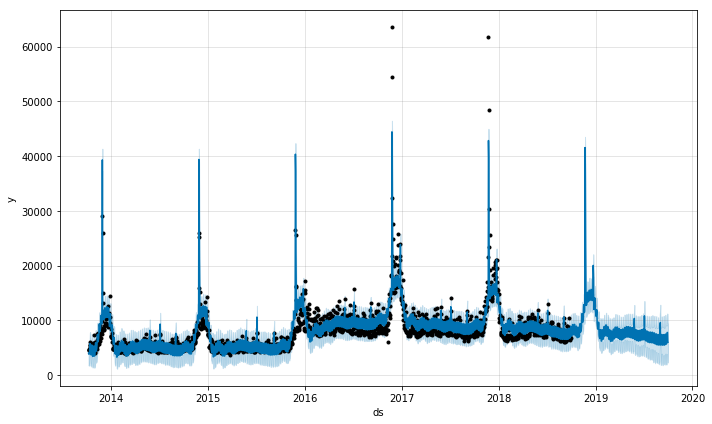

In [40]:
fig1 = m.plot(forecast)

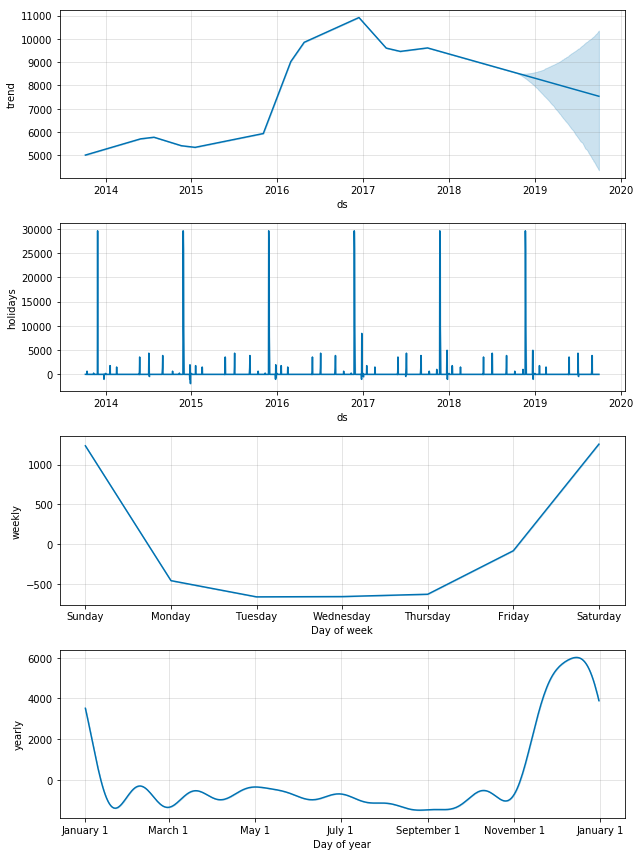

In [41]:
fig = m.plot_components(forecast)

In [42]:
forecast.to_csv('forecast.csv')

In [43]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value'] = prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresiduals'] = abs(erroranalysis['residuals'])

erroranalysis.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresiduals
0,2013-10-07,5011.841552,1921.800608,6012.483865,5011.841552,5011.841552,0.0,0.0,0.0,0.0,...,-572.875405,-572.875405,-572.875405,0.0,0.0,0.0,3979.605679,4643.368256,663.762577,663.762577
1,2013-10-08,5014.820366,1513.685692,5834.822676,5014.820366,5014.820366,0.0,0.0,0.0,0.0,...,-548.643365,-548.643365,-548.643365,0.0,0.0,0.0,3802.497387,4492.723981,690.226594,690.226594
2,2013-10-09,5017.799181,1763.611233,5999.822481,5017.799181,5017.799181,0.0,0.0,0.0,0.0,...,-532.838394,-532.838394,-532.838394,0.0,0.0,0.0,3824.978477,4503.579896,678.601419,678.601419
3,2013-10-10,5020.777995,1868.080660,5992.212751,5020.777995,5020.777995,0.0,0.0,0.0,0.0,...,-525.877272,-525.877272,-525.877272,0.0,0.0,0.0,3864.177955,4741.994493,877.816538,877.816538
4,2013-10-11,5023.756810,2368.205584,6624.612517,5023.756810,5023.756810,0.0,0.0,0.0,0.0,...,-527.954112,-527.954112,-527.954112,0.0,0.0,0.0,4412.785842,5034.404350,621.618508,621.618508


In [44]:
#look at the average total error and take the sq root, to get an approximate root mean square error
totalerror = erroranalysis['absoluteresiduals'].sum()

In [45]:
print(totalerror/len(erroranalysis)) # this number is an improvement over the previous model!

885.893228813741


Adding the holidays did improve my model since the total error decreased from 1151.18 to 885.89, almost 24% decrease! This also 
made sure that the holiday sales were taken into account

#### AdSpend Analysis

In [46]:
adspend = pd.read_csv('macys.adspend.csv')

In [47]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"WEEK OF OCT 07, 2013 (B)",Go Red For Women/Macys & Merck : Sponsored Event,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"WEEK OF OCT 07, 2013 (B)",Go Red For Women/Macys : Sponsored Event,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"WEEK OF OCT 07, 2013 (B)",Macys : Fragrances & Cosmetics,1530.2,0.0,0.0,0.0,0.0,0.0,0.0,106.7,1423.5,0.0,0.0,0.0
3,"WEEK OF OCT 07, 2013 (B)",Macys : Furniture & Home Decor,225.6,0.0,0.0,0.0,0.0,0.0,0.0,10.6,215.0,0.0,0.0,0.0
4,"WEEK OF OCT 07, 2013 (B)",Macys : Furniture & Home Decor & Mattresses,59.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.9,0.0,0.0,0.0


In [48]:
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF ", "", regex=True)

In [49]:
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("\(B\)", "", regex = True) #\escape character

In [50]:
adspend.head()

,TIME PERIOD,PRODUCT,TOTAL DOLS (000),NETWORK TV DOLS (000),CABLE TV DOLS (000),SYNDICATION DOLS (000),SPOT TV DOLS (000),MAGAZINES DOLS (000),SUNDAY MAGS DOLS (000),NATL NEWSP DOLS (000),NEWSPAPER DOLS (000),NETWORK RADIO DOLS (000),NAT SPOT RADIO DOLS (000),OUTDOOR DOLS (000)
0,"OCT 07, 2013",Go Red For Women/Macys & Merck : Sponsored Event,0.2,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"OCT 07, 2013",Go Red For Women/Macys : Sponsored Event,0.3,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"OCT 07, 2013",Macys : Fragrances & Cosmetics,1530.2,0.0,0.0,0.0,0.0,0.0,0.0,106.7,1423.5,0.0,0.0,0.0
3,"OCT 07, 2013",Macys : Furniture & Home Decor,225.6,0.0,0.0,0.0,0.0,0.0,0.0,10.6,215.0,0.0,0.0,0.0
4,"OCT 07, 2013",Macys : Furniture & Home Decor & Mattresses,59.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.9,0.0,0.0,0.0


In [51]:
adspend.columns = adspend.columns.str.replace(" DOLS \(000\)", "", regex = True) #\escape character

In [52]:
#adspend.head()
list(adspend)

['TIME PERIOD',
 'PRODUCT',
 'TOTAL',
 'NETWORK TV',
 'CABLE TV',
 'SYNDICATION',
 'SPOT TV',
 'MAGAZINES',
 'SUNDAY MAGS',
 'NATL NEWSP',
 'NEWSPAPER',
 'NETWORK RADIO',
 'NAT SPOT RADIO',
 'OUTDOOR']

In [53]:
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD'])

In [54]:
#Get rid of' 'products and find the total ad spend per week. Like a pivot table in excel
import numpy as np
adspendnoproducts=adspend.pivot_table(index='FIXED TIME', aggfunc=np.sum)

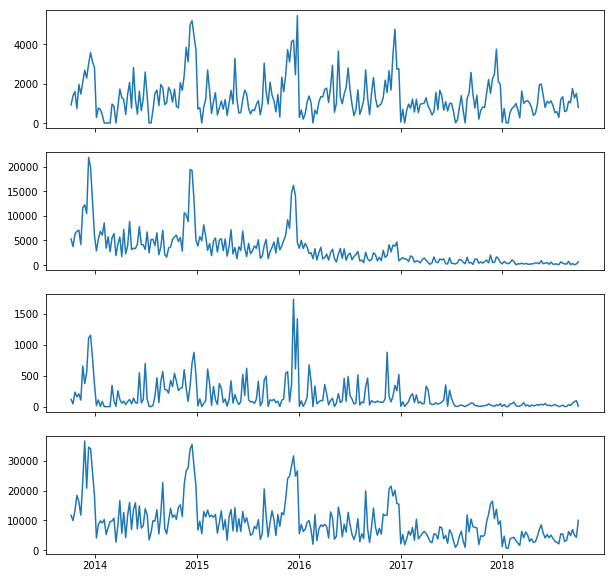

In [55]:
import matplotlib.pyplot as pyplot
dimensions = (10, 10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize=dimensions, sharex='all') # have the one x axis printed for all 4 graphs instead of for each graph

ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV']) #Spot cable is one of two basic ways to buy advertising on cable television. It allows regional small-business owners to show their TV ads on national cable networks that air in their local markets without having to buy airtime from those networks.
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])


In [56]:
testdate = pd.to_datetime("2013-10-07")

In [57]:
testdate.weekday() # this is monday

0

In [58]:
macys = pd.read_csv('macys.googletrends.csv', parse_dates=['period'])

In [59]:
macys.set_index('period', inplace=True)

In [60]:
#macys.head()
macysweekly = macys.resample('W-MON', closed = 'left', label = 'left').mean()
# first parameter - unit of analysis W-weekly, M-monthly, D- daily 
# second parameter - where would we close the data. where do we start the week? Left or right? [0 1 2 3 4 5 6]
# third parameter - label


In [61]:
macysweekly.head()

,Unnamed: 0,value
period,,
2013-10-07,3,4984.998247
2013-10-14,10,5092.498522
2013-10-21,17,5333.864822
2013-10-28,24,4860.332165
2013-11-04,31,5886.632084


In [62]:
mergedweeklydata = adspendnoproducts.join(macysweekly)

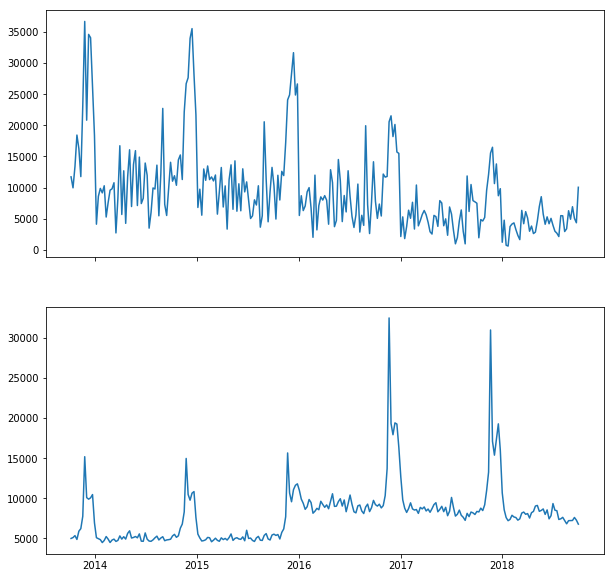

In [63]:
dimensions = (10, 10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex = 'all')

ax1.plot(mergedweeklydata.index, mergedweeklydata['TOTAL'])
ax2.plot(mergedweeklydata.index, mergedweeklydata['value'])

In [64]:
mergedweeklydata['TOTAL'].corr(mergedweeklydata['value'])

0.2782451809859013

The correlation is rather high at almost 28%. We need stationary data for Time Series, but there is a slight downward trend in the first graph and slight upward trend in the second. Hence calculate the one diff value.

In [65]:
mergedweeklydata['TOTALdiff'] = mergedweeklydata['TOTAL'].diff(1)
mergedweeklydata['valuediff'] = mergedweeklydata['value'].diff(1)

In [66]:
mergedweeklydata.head()

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK RADIO,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,SUNDAY MAGS,SYNDICATION,TOTAL,Unnamed: 0,value,TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,,,,
2013-10-07,920.3,194.5,116.7,334.9,485.9,3880.9,5296.4,0.0,117.7,0.0,364.2,11711.7,3,4984.998247,NaN,NaN
2013-10-14,1376.9,194.5,116.7,439.0,485.9,3394.9,3756.4,0.0,44.6,0.0,138.5,9947.5,10,5092.498522,-1764.2,107.500275
2013-10-21,1599.4,176.8,116.7,260.3,485.9,3465.8,6269.9,0.0,234.5,0.0,750.9,13360.4,17,5333.864822,3412.9,241.366300
2013-10-28,732.5,6425.8,181.5,925.7,495.0,1853.7,6875.8,364.3,157.8,235.6,174.3,18422.0,24,4860.332165,5061.6,-473.532657
2013-11-04,1962.0,194.5,267.8,1328.3,507.0,4011.5,7087.7,0.0,205.2,0.0,685.1,16249.1,31,5886.632084,-2172.9,1026.299919


In [67]:
mergedweeklydata['TOTALdiff'].corr(mergedweeklydata['valuediff']) #slight increase in the value. run adf on the original data and check if the data is already stationary

0.28543532190979437

There is a slight increase in the value, from approximately 28% to 28.5%

In [68]:
mergedweeklydata.to_csv('adspend.googletrends.weekly.csv')

Causality in Time Series Analysis implies a lag in adspend to googletrends values. However in predictive analytics, there is no concept of lag, that is a change in X value, causes a change in Y, without considering the time lag. If both X and Y increase at the same time, there could be an external factor like the economy. However in digital advertising, this need not be true. 
Granger causality explores if this lag is a week, 2 weeks or a month or not at all. Also, we have different types of ad spend here. Just one specific type of spend might actually drive google trends, instead of the total spend!

#### Correlations and Lags

In [69]:
adspend_trends = pd.read_csv('adspend.googletrends.weekly.csv', parse_dates=['FIXED TIME'])

In [70]:
adspend_trends.set_index('FIXED TIME', inplace=True)

In [71]:
list(adspend_trends)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK RADIO',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'SUNDAY MAGS',
 'SYNDICATION',
 'TOTAL',
 'Unnamed: 0',
 'value',
 'TOTALdiff',
 'valuediff']

In [72]:
#adspend_trends = adspend_trends.drop(columns=['onediffvalue','Unnamed:0','TOTALdiff','valuediff'])
adspend_trends = adspend_trends.drop(columns=['Unnamed: 0', 'TOTALdiff', 'valuediff'])

In [73]:
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print(adf_result)

(-6.605422779771655, 6.575272737133018e-09, 1, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 3978.224058003031)
(-2.3419322419122315, 0.15880028493905796, 13, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 4184.126245443005)
(-4.078924096512601, 0.001049199418456151, 13, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2577.262236767369)
(-4.8258822501140095, 4.851334659600437e-05, 7, 253, {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}, 3150.5280497208432)
(-4.375226286407212, 0.000328275987778512, 6, 254, {'1%': -3.456360306409983, '5%': -2.8729872043802356, '10%': -2.572870232500465}, 2653.3210665662823)
(-6.134129300229509, 8.265393499160732e-08, 7, 253, {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}, 4279.821872880654)
(-3.292918090424672, 0.015198019149293703, 4, 256, {'1%': -3.4561550092339512, '

In [74]:
adspend_trends_diff = pd.DataFrame()

In [75]:
for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1)
    

In [76]:
adspend_trends_diff.head()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SUNDAY MAGS_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,456.6,0.0,0.0,104.1,0.0,-486.0,-1540.0,0.0,-73.1,0.0,-225.7,-1764.2,107.500275
2013-10-21,222.5,-17.7,0.0,-178.7,0.0,70.9,2513.5,0.0,189.9,0.0,612.4,3412.9,241.366300
2013-10-28,-866.9,6249.0,64.8,665.4,9.1,-1612.1,605.9,364.3,-76.7,235.6,-576.6,5061.6,-473.532657
2013-11-04,1229.5,-6231.3,86.3,402.6,12.0,2157.8,211.9,-364.3,47.4,-235.6,510.8,-2172.9,1026.299919


In [77]:
for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:]) # slicing this variable to start at row 2 instead of row 1
    print(adf_result[1])
    

1.370484836787774e-07
1.7145275433070862e-17
1.013903068623559e-18
4.1280112080707965e-13
5.530646202819046e-20
1.9834064780080888e-11
2.474786161981476e-21
1.781651513757181e-14
3.07803716599485e-11
1.0994710954956923e-17
3.148209943340254e-13
3.61948207742758e-15
1.2624012245134884e-11


In [78]:
correlationlist = []
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value_diff'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV_diff 0.20789999587192182
MAGAZINES_diff -0.05525133147748119
NAT SPOT RADIO_diff 0.010340186119204791
NATL NEWSP_diff 0.2815171944452248
NETWORK RADIO_diff 0.0024560419559765414
NETWORK TV_diff 0.49911501237084455
NEWSPAPER_diff 0.1958168960927746
OUTDOOR_diff -0.06816013301320537
SPOT TV_diff 0.054219766899214344
SUNDAY MAGS_diff -0.14223684991893182
SYNDICATION_diff 0.05921353687884026
TOTAL_diff 0.2854353219097943


In [79]:
np.mean(correlationlist)

0.11086380317784815

In [80]:
correlationlist = []
for acolumn in list(adspend_trends):
    if "value" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends['value'])
        print(acolumn, corr)
        correlationlist.append(corr)

CABLE TV 0.3991561188473928
MAGAZINES 0.01597947933388928
NAT SPOT RADIO 0.2207625808059347
NATL NEWSP 0.16451161300083242
NETWORK RADIO 0.20086000140939395
NETWORK TV 0.5890953987177385
NEWSPAPER -0.009686001506765596
OUTDOOR 0.1491356437421267
SPOT TV 0.10275324135548053
SUNDAY MAGS -0.03350924792368866
SYNDICATION 0.43003148004516567
TOTAL 0.2782451809859013


In [81]:
np.mean(correlationlist) # stationary data models better since the mean is higher

0.20894462406778347

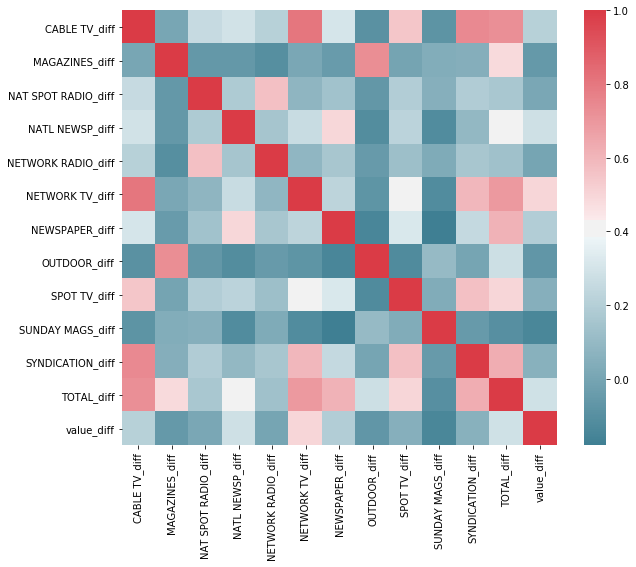

In [82]:
f, ax = pyplot.subplots(figsize=(10,8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap= True),
            square = True, ax=ax)

The highest correlation exists with Network TV, so increasing spend on Network TV helps with getting more interest in google search. This proves the analysis that one particular type of spend might drive the search interest more than the others, in this case, Network TV.

In [83]:
# granger causality : checks if one variable is granger causal for another variable at a specific lag
# first thing is to decide how many weeks we want for the lag.
# Here we choose 8 weeks or two months since most advertisements effect are immediate with the exception of magazines
# check if your brand works better with a greater lag

numofweeks = 8
# check which ones are the most significant lags
significantlags = []

for acolumn in list(adspend_trends_diff):
    if 'value' not in acolumn:
        testframe = adspend_trends_diff[['value_diff', acolumn]] # double brackets allow us to reference columns
        #make a new DF with google trends value column that we're trying to predict and a second column is the predictor
        testframe = testframe.iloc[1:] # remove 1st row, so nan value is removed
        results = stattools.grangercausalitytests(testframe, numofweeks, verbose=False)
        for week in range(1,numofweeks+1): #start at 1 and goes upto week 8, since the range functionality goes upto 8-1
            if results[week][0]['params_ftest'][1] < 0.05: #parse thru dict to get significance of f test
                print ('%s is significant at %s weeks' %(acolumn, week))
                significantlags.append(week) # append the week number where the f test is significant to the significantlags 


CABLE TV_diff is significant at 1 weeks
CABLE TV_diff is significant at 2 weeks
CABLE TV_diff is significant at 3 weeks
CABLE TV_diff is significant at 4 weeks
CABLE TV_diff is significant at 5 weeks
CABLE TV_diff is significant at 6 weeks
CABLE TV_diff is significant at 7 weeks
NAT SPOT RADIO_diff is significant at 3 weeks
NAT SPOT RADIO_diff is significant at 7 weeks
NAT SPOT RADIO_diff is significant at 8 weeks
NATL NEWSP_diff is significant at 3 weeks
NATL NEWSP_diff is significant at 4 weeks
NETWORK RADIO_diff is significant at 7 weeks
NETWORK RADIO_diff is significant at 8 weeks
NETWORK TV_diff is significant at 2 weeks
NETWORK TV_diff is significant at 3 weeks
NETWORK TV_diff is significant at 4 weeks
NETWORK TV_diff is significant at 5 weeks
NETWORK TV_diff is significant at 6 weeks
NETWORK TV_diff is significant at 7 weeks
NETWORK TV_diff is significant at 8 weeks
NEWSPAPER_diff is significant at 1 weeks
OUTDOOR_diff is significant at 1 weeks
OUTDOOR_diff is significant at 2 w

In [84]:
#mode(significantlags)

In [85]:
modelingdatset = adspend_trends_diff

In [86]:
modelingdatset.tail()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK RADIO_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,SUNDAY MAGS_diff,SYNDICATION_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,,,,
2018-09-03,-74.7,0.0,119.7,-60.4,110.5,-556.0,-659.2,-106.4,-14.5,0.0,-126.0,-1367.1,14.701073
2018-09-10,723.4,0.0,0.0,12.0,0.0,603.2,218.7,0.0,36.4,0.0,417.2,2010.9,6.598672
2018-09-17,-474.4,0.0,0.0,-27.6,0.0,-846.8,-255.0,0.0,24.9,0.0,-288.3,-1867.1,376.007480
2018-09-24,221.6,0.0,0.0,10.5,0.0,-1298.7,180.4,0.0,17.1,0.0,158.2,-711.2,-331.703024
2018-10-01,-709.3,4306.9,-240.7,65.5,-113.6,1877.8,427.6,127.4,-88.9,0.0,46.1,5698.8,-498.788396


Let's create seven weeks of lag since we have 7 week lags for most of the advertising channels

In [88]:
date = pd.to_datetime('2018-10-08')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-10-15')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-10-22')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-10-29')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-11-05')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-11-12')
modelingdatset.loc[date] = np.nan

date = pd.to_datetime('2018-11-19')
modelingdatset.loc[date] = np.nan

In [89]:
for acolumn in list(modelingdatset):
    if 'value' not in acolumn:
        for alag in range(1,8): # change the value 3, to increase the number of lag weeks
            columnname = '%s_lag%s' %(acolumn, alag)
            modelingdatset[columnname] = modelingdatset[acolumn].shift(alag) # shifting in +ve direction, moves it down, -ve move it up
            #here we are shifting it down
            

In [90]:
modelingdatset.sort_index(axis = 1, inplace = True) # sort by columns, instead of rows(0)
modelingdatset.head()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,CABLE TV_diff_lag5,CABLE TV_diff_lag6,CABLE TV_diff_lag7,MAGAZINES_diff,MAGAZINES_diff_lag1,...,SYNDICATION_diff_lag7,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,TOTAL_diff_lag5,TOTAL_diff_lag6,TOTAL_diff_lag7,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,456.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,-1764.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.500275
2013-10-21,222.5,456.6,NaN,NaN,NaN,NaN,NaN,NaN,-17.7,0.0,...,NaN,3412.9,-1764.2,NaN,NaN,NaN,NaN,NaN,NaN,241.366300
2013-10-28,-866.9,222.5,456.6,NaN,NaN,NaN,NaN,NaN,6249.0,-17.7,...,NaN,5061.6,3412.9,-1764.2,NaN,NaN,NaN,NaN,NaN,-473.532657
2013-11-04,1229.5,-866.9,222.5,456.6,NaN,NaN,NaN,NaN,-6231.3,6249.0,...,NaN,-2172.9,5061.6,3412.9,-1764.2,NaN,NaN,NaN,NaN,1026.299919


In [91]:
modelingdatset.to_csv('google_adspend_differenced_lagged_fordatarobot.csv')

In [92]:
alldata = pd.read_csv("google_adspend_differenced_lagged_fordatarobot.csv")

In [93]:
alldata.set_index(alldata['FIXED TIME'], inplace = True)

In [94]:
list(alldata)

['FIXED TIME',
 'CABLE TV_diff',
 'CABLE TV_diff_lag1',
 'CABLE TV_diff_lag2',
 'CABLE TV_diff_lag3',
 'CABLE TV_diff_lag4',
 'CABLE TV_diff_lag5',
 'CABLE TV_diff_lag6',
 'CABLE TV_diff_lag7',
 'MAGAZINES_diff',
 'MAGAZINES_diff_lag1',
 'MAGAZINES_diff_lag2',
 'MAGAZINES_diff_lag3',
 'MAGAZINES_diff_lag4',
 'MAGAZINES_diff_lag5',
 'MAGAZINES_diff_lag6',
 'MAGAZINES_diff_lag7',
 'NAT SPOT RADIO_diff',
 'NAT SPOT RADIO_diff_lag1',
 'NAT SPOT RADIO_diff_lag2',
 'NAT SPOT RADIO_diff_lag3',
 'NAT SPOT RADIO_diff_lag4',
 'NAT SPOT RADIO_diff_lag5',
 'NAT SPOT RADIO_diff_lag6',
 'NAT SPOT RADIO_diff_lag7',
 'NATL NEWSP_diff',
 'NATL NEWSP_diff_lag1',
 'NATL NEWSP_diff_lag2',
 'NATL NEWSP_diff_lag3',
 'NATL NEWSP_diff_lag4',
 'NATL NEWSP_diff_lag5',
 'NATL NEWSP_diff_lag6',
 'NATL NEWSP_diff_lag7',
 'NETWORK RADIO_diff',
 'NETWORK RADIO_diff_lag1',
 'NETWORK RADIO_diff_lag2',
 'NETWORK RADIO_diff_lag3',
 'NETWORK RADIO_diff_lag4',
 'NETWORK RADIO_diff_lag5',
 'NETWORK RADIO_diff_lag6',
 'NETW

In [95]:
alldata = alldata.drop(columns = ['FIXED TIME'])

In [96]:
alldata.head()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,CABLE TV_diff_lag5,CABLE TV_diff_lag6,CABLE TV_diff_lag7,MAGAZINES_diff,MAGAZINES_diff_lag1,...,SYNDICATION_diff_lag7,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,TOTAL_diff_lag5,TOTAL_diff_lag6,TOTAL_diff_lag7,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,456.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,-1764.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.500275
2013-10-21,222.5,456.6,NaN,NaN,NaN,NaN,NaN,NaN,-17.7,0.0,...,NaN,3412.9,-1764.2,NaN,NaN,NaN,NaN,NaN,NaN,241.366300
2013-10-28,-866.9,222.5,456.6,NaN,NaN,NaN,NaN,NaN,6249.0,-17.7,...,NaN,5061.6,3412.9,-1764.2,NaN,NaN,NaN,NaN,NaN,-473.532657
2013-11-04,1229.5,-866.9,222.5,456.6,NaN,NaN,NaN,NaN,-6231.3,6249.0,...,NaN,-2172.9,5061.6,3412.9,-1764.2,NaN,NaN,NaN,NaN,1026.299919


In [97]:
alldata = alldata.iloc[8:]

In [98]:
alldata.head() # keep dropping rows until we don't see any Nan values in the first row


,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,CABLE TV_diff_lag5,CABLE TV_diff_lag6,CABLE TV_diff_lag7,MAGAZINES_diff,MAGAZINES_diff_lag1,...,SYNDICATION_diff_lag7,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,TOTAL_diff_lag5,TOTAL_diff_lag6,TOTAL_diff_lag7,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-12-02,-389.8,596.6,607.7,-493.6,1229.5,-866.9,222.5,456.6,-7826.4,7596.4,...,-225.7,-15861.8,13547.3,11376.0,-4498.2,-2172.9,5061.6,3412.9,-1764.2,-5100.450025
2013-12-09,720.2,-389.8,596.6,607.7,-493.6,1229.5,-866.9,222.5,17.7,-7826.4,...,612.4,13778.7,-15861.8,13547.3,11376.0,-4498.2,-2172.9,5061.6,3412.9,-190.660710
2013-12-16,572.0,720.2,-389.8,596.6,607.7,-493.6,1229.5,-866.9,0.0,17.7,...,-576.6,-536.1,13778.7,-15861.8,13547.3,11376.0,-4498.2,-2172.9,5061.6,160.625972
2013-12-23,-491.7,572.0,720.2,-389.8,596.6,607.7,-493.6,1229.5,88.4,0.0,...,510.8,-7795.7,-536.1,13778.7,-15861.8,13547.3,11376.0,-4498.2,-2172.9,412.118945
2013-12-30,-254.7,-491.7,572.0,720.2,-389.8,596.6,607.7,-493.6,515.7,88.4,...,-258.6,-7909.7,-7795.7,-536.1,13778.7,-15861.8,13547.3,11376.0,-4498.2,-3531.905203


In [99]:
alldata.tail() # slice out last eight rows since they have NaN values

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,CABLE TV_diff_lag5,CABLE TV_diff_lag6,CABLE TV_diff_lag7,MAGAZINES_diff,MAGAZINES_diff_lag1,...,SYNDICATION_diff_lag7,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,TOTAL_diff_lag5,TOTAL_diff_lag6,TOTAL_diff_lag7,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2018-10-22,NaN,NaN,NaN,-709.3,221.6,-474.4,723.4,-74.7,NaN,NaN,...,-126.0,NaN,NaN,NaN,5698.8,-711.2,-1867.1,2010.9,-1367.1,NaN
2018-10-29,NaN,NaN,NaN,NaN,-709.3,221.6,-474.4,723.4,NaN,NaN,...,417.2,NaN,NaN,NaN,NaN,5698.8,-711.2,-1867.1,2010.9,NaN
2018-11-05,NaN,NaN,NaN,NaN,NaN,-709.3,221.6,-474.4,NaN,NaN,...,-288.3,NaN,NaN,NaN,NaN,NaN,5698.8,-711.2,-1867.1,NaN
2018-11-12,NaN,NaN,NaN,NaN,NaN,NaN,-709.3,221.6,NaN,NaN,...,158.2,NaN,NaN,NaN,NaN,NaN,NaN,5698.8,-711.2,NaN
2018-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-709.3,NaN,NaN,...,46.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5698.8,NaN


In [100]:
alldata = alldata.iloc[:-8]

In [101]:
alldata.tail()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,CABLE TV_diff_lag5,CABLE TV_diff_lag6,CABLE TV_diff_lag7,MAGAZINES_diff,MAGAZINES_diff_lag1,...,SYNDICATION_diff_lag7,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,TOTAL_diff_lag5,TOTAL_diff_lag6,TOTAL_diff_lag7,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2018-08-27,477.6,47.2,-760.1,136.8,917.6,-294.8,50.6,-357.9,0.0,0.0,...,181.3,2896.8,443.2,-2525.2,-22.4,3356.8,-543.4,-310.9,-959.1,391.633100
2018-09-03,-74.7,477.6,47.2,-760.1,136.8,917.6,-294.8,50.6,0.0,0.0,...,152.9,-1367.1,2896.8,443.2,-2525.2,-22.4,3356.8,-543.4,-310.9,14.701073
2018-09-10,723.4,-74.7,477.6,47.2,-760.1,136.8,917.6,-294.8,0.0,0.0,...,-22.6,2010.9,-1367.1,2896.8,443.2,-2525.2,-22.4,3356.8,-543.4,6.598672
2018-09-17,-474.4,723.4,-74.7,477.6,47.2,-760.1,136.8,917.6,0.0,0.0,...,283.5,-1867.1,2010.9,-1367.1,2896.8,443.2,-2525.2,-22.4,3356.8,376.007480
2018-09-24,221.6,-474.4,723.4,-74.7,477.6,47.2,-760.1,136.8,0.0,0.0,...,265.3,-711.2,-1867.1,2010.9,-1367.1,2896.8,443.2,-2525.2,-22.4,-331.703024


In [102]:
#make your list of predictors for Lasso
listofallpredictors = []
for avar in list(alldata):
    if "value" not in avar:
        listofallpredictors.append(avar)

In [103]:
print(listofallpredictors)

['CABLE TV_diff', 'CABLE TV_diff_lag1', 'CABLE TV_diff_lag2', 'CABLE TV_diff_lag3', 'CABLE TV_diff_lag4', 'CABLE TV_diff_lag5', 'CABLE TV_diff_lag6', 'CABLE TV_diff_lag7', 'MAGAZINES_diff', 'MAGAZINES_diff_lag1', 'MAGAZINES_diff_lag2', 'MAGAZINES_diff_lag3', 'MAGAZINES_diff_lag4', 'MAGAZINES_diff_lag5', 'MAGAZINES_diff_lag6', 'MAGAZINES_diff_lag7', 'NAT SPOT RADIO_diff', 'NAT SPOT RADIO_diff_lag1', 'NAT SPOT RADIO_diff_lag2', 'NAT SPOT RADIO_diff_lag3', 'NAT SPOT RADIO_diff_lag4', 'NAT SPOT RADIO_diff_lag5', 'NAT SPOT RADIO_diff_lag6', 'NAT SPOT RADIO_diff_lag7', 'NATL NEWSP_diff', 'NATL NEWSP_diff_lag1', 'NATL NEWSP_diff_lag2', 'NATL NEWSP_diff_lag3', 'NATL NEWSP_diff_lag4', 'NATL NEWSP_diff_lag5', 'NATL NEWSP_diff_lag6', 'NATL NEWSP_diff_lag7', 'NETWORK RADIO_diff', 'NETWORK RADIO_diff_lag1', 'NETWORK RADIO_diff_lag2', 'NETWORK RADIO_diff_lag3', 'NETWORK RADIO_diff_lag4', 'NETWORK RADIO_diff_lag5', 'NETWORK RADIO_diff_lag6', 'NETWORK RADIO_diff_lag7', 'NETWORK TV_diff', 'NETWORK TV_d

In [104]:
predictors = alldata[listofallpredictors] 
# put all columns and data corresponding to listofallpredictors

In [106]:
target = alldata['value_diff']

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
import matplotlib.pyplot as pyplot
import warnings 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [108]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target, test_size = 0.3, random_state = 123)
# now prepare the training and test set for the predictors and target we're using 70/30 train, test

In [109]:
model = LassoLarsCV(cv=10, precompute = False)

In [110]:
model = model.fit(pred_train.values, tar_train.values)

In [111]:
predictors_model = pd.DataFrame(listofallpredictors)
predictors_model.columns = ['label']
predictors_model['coeff'] = model.coef_

In [112]:
for index, row in predictors_model.iterrows():
    if row['coeff'] > 0:
        print(row.values)

['NATL NEWSP_diff' 1.25692811350319]
['NATL NEWSP_diff_lag1' 1.6634023143564585]
['NETWORK RADIO_diff_lag3' 2.7593670158903048]
['NETWORK RADIO_diff_lag7' 3.2539881225481655]
['NETWORK TV_diff' 0.8327082882376675]
['NEWSPAPER_diff_lag5' 0.0037747662484690623]
['NEWSPAPER_diff_lag7' 0.028167456795375634]
['OUTDOOR_diff_lag3' 0.4729626834594522]
['SPOT TV_diff_lag1' 0.8192844858385404]
['SUNDAY MAGS_diff_lag2' 0.026211353568031424]
['SYNDICATION_diff_lag1' 0.482108284418589]


In [113]:
train_error = mean_squared_error(tar_train, model.predict(pred_train))
print('training data MSE')
print(train_error)

training data MSE
1648392.4904229515


In [114]:
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print('test data MSE')
print(test_error)

test data MSE
4003363.610996866


The MSE values are rather high. Let's look at the r squared values now.

In [115]:
rsquared_train = model.score(pred_train, tar_train)
print('training data r-square')
print(rsquared_train)

training data r-square
0.7133624543183019


In [116]:
rsquared_test = model.score(pred_test, tar_test)
print('test data r-square')

print(rsquared_test)

test data r-square
0.27104777326455154


The training set r squared value is rather good at 71.34% while the test data r-squared value is at 27%. Now let's tale a look at the twitter data for macys and compare how its values look against the google search trends.

In [130]:
macystwitter = pd.read_csv('macystwitterdata.csv', parse_dates=['datetime'])

In [131]:
macystwitter['datetime'] = macystwitter['datetime'].dt.date
    

In [132]:
macystwitter.set_index('datetime', inplace=True)

In [133]:
twitter = macystwitter.join(macys)

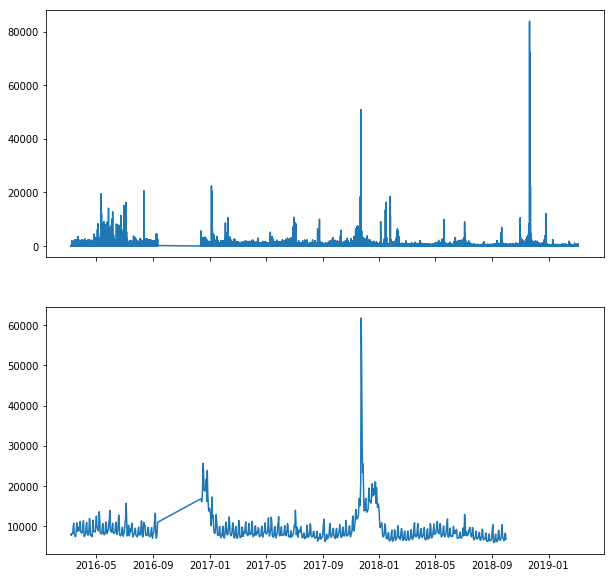

In [135]:
dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex='all')

ax1.plot(twitter.index, twitter['count'])
ax2.plot(twitter.index, twitter['value'])

This is pretty interesting. The twitter data shows extremely high activity around the end of November in 2017. This co incides with the Black Friday Sale again, as confirmed in all of the previous analyses. Around the time the 64 stores were closed, there seems to have been incessant twitter activity about the brand Macys. 
In addition there is missing data in the last quarter of 2016. This was due to manual error in extracting data from the social site. Now, lets see if there exists a correlation between Twitter Activity and Google Search.

#### Correlation between Twitter Activity and Google Search

In [136]:
twitter['count'].corr(twitter['value'])

0.06853979461160514

This shows about 7% correlation. This is quite a good number.

Overall, it would suffice to say that the google trends data displays a clear seasonal trend for Macy's, with its most prominent holiday being the Black Friday sales. There are additional peaks around Christmas and New Years and minor peaks around back to school season. 
The Prophet model is very accurate especially after including the holidays since the residual errors drop significantly. Network TV is the best form of advertising that drives search interest. 
There are 4 clear outliers, two each in late 2016 and late 2017, that correspond to the massive numbers of stores that were closed due to bad sales figures, thereby closing sales announced at these stores.
Twitter data also reflects the same fact by the peak in late November 2017 and also proving that google search and twitter activity are correlated for this brand.
